<a href="https://colab.research.google.com/github/mrandrivan/ML-DL-AI-practice/blob/main/time_series_analyses_S%26P.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

New Time Series Analyses on S&P 500 index
Trying to predict future stock prices based on past behaviour.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error


1. Import the data into the session

In [2]:
# Load the data
data = pd.read_csv('stock.csv', parse_dates=['Date'], index_col='Date')
# Display the first few rows
data.head()




,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
Date,,,,,,,,,
2012-01-12,60.198570,75.510002,30.120001,12.13,175.929993,180.550003,28.250000,313.644379,1295.500000
2012-01-13,59.972858,74.599998,30.070000,12.35,178.419998,179.160004,22.790001,311.328064,1289.089966
2012-01-17,60.671429,75.239998,30.250000,12.25,181.660004,180.000000,26.600000,313.116364,1293.670044
2012-01-18,61.301430,75.059998,30.330000,12.73,189.440002,181.070007,26.809999,315.273285,1308.040039
2012-01-19,61.107143,75.559998,30.420000,12.80,194.449997,180.520004,26.760000,318.590851,1314.500000


In [3]:
# Check for missing values
data.isnull().sum()

# Fill or drop missing values as needed
data = data.fillna(method='ffill')

# Convert data to a time series format if necessary
data.index = pd.to_datetime(data.index)

data.head()

# Resample the data to a daily frequency and fill missing values
data = data.resample('D').interpolate()


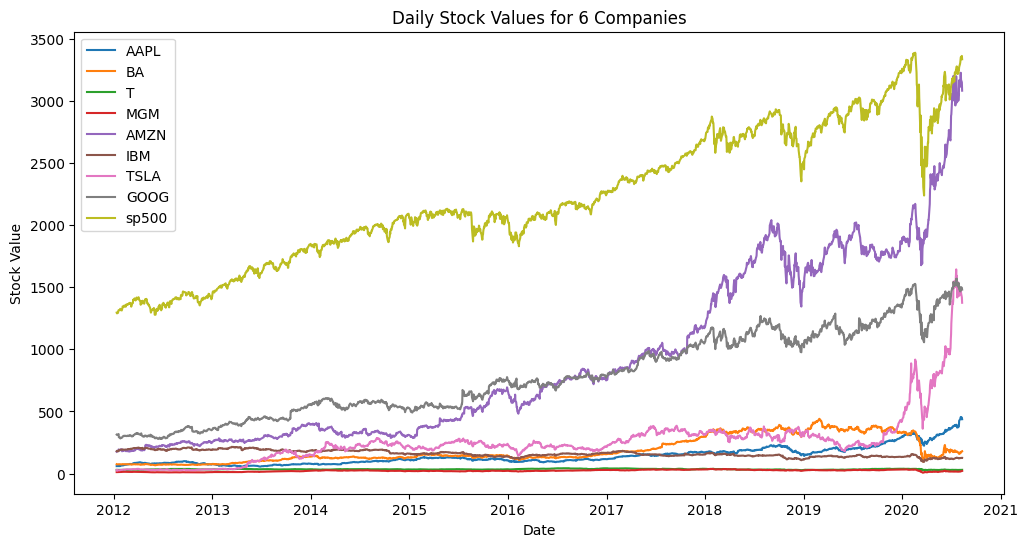

In [4]:
#Visualize the data to see the outliers etc.

plt.figure(figsize=(12, 6))
for column in data.columns:
    plt.plot(data.index, data[column], label=column)
plt.title('Daily Stock Values for 6 Companies')
plt.xlabel('Date')
plt.ylabel('Stock Value')
plt.legend()
plt.show()

**2. Start decomposing the data and prepare time series analyses**

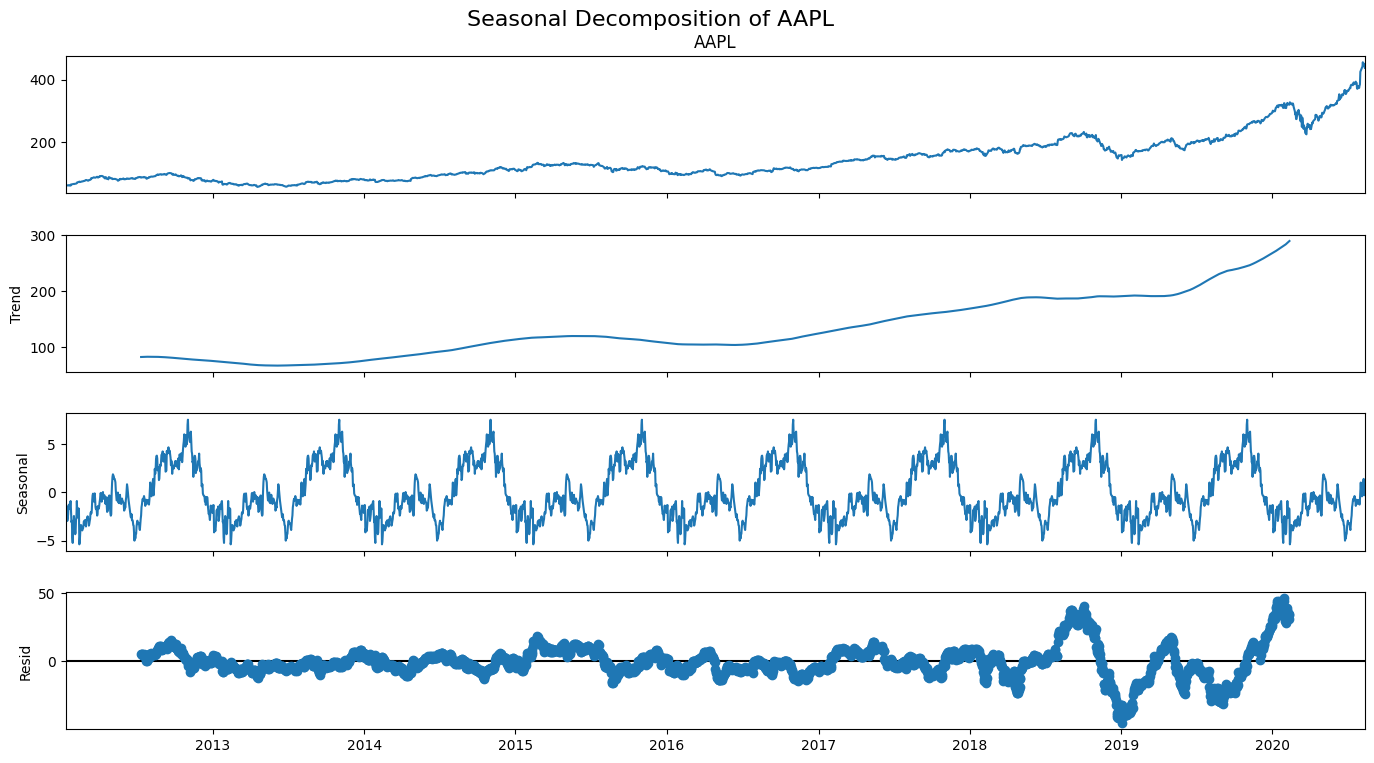

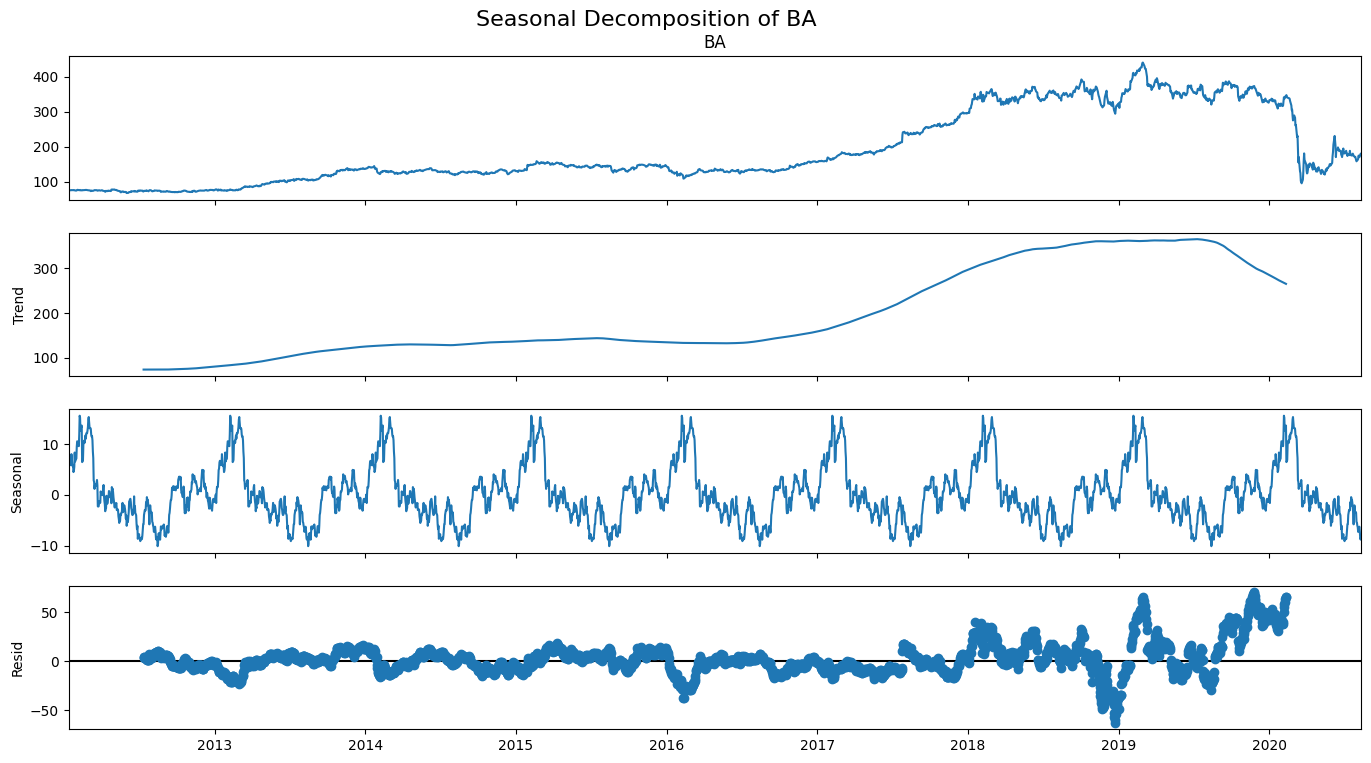

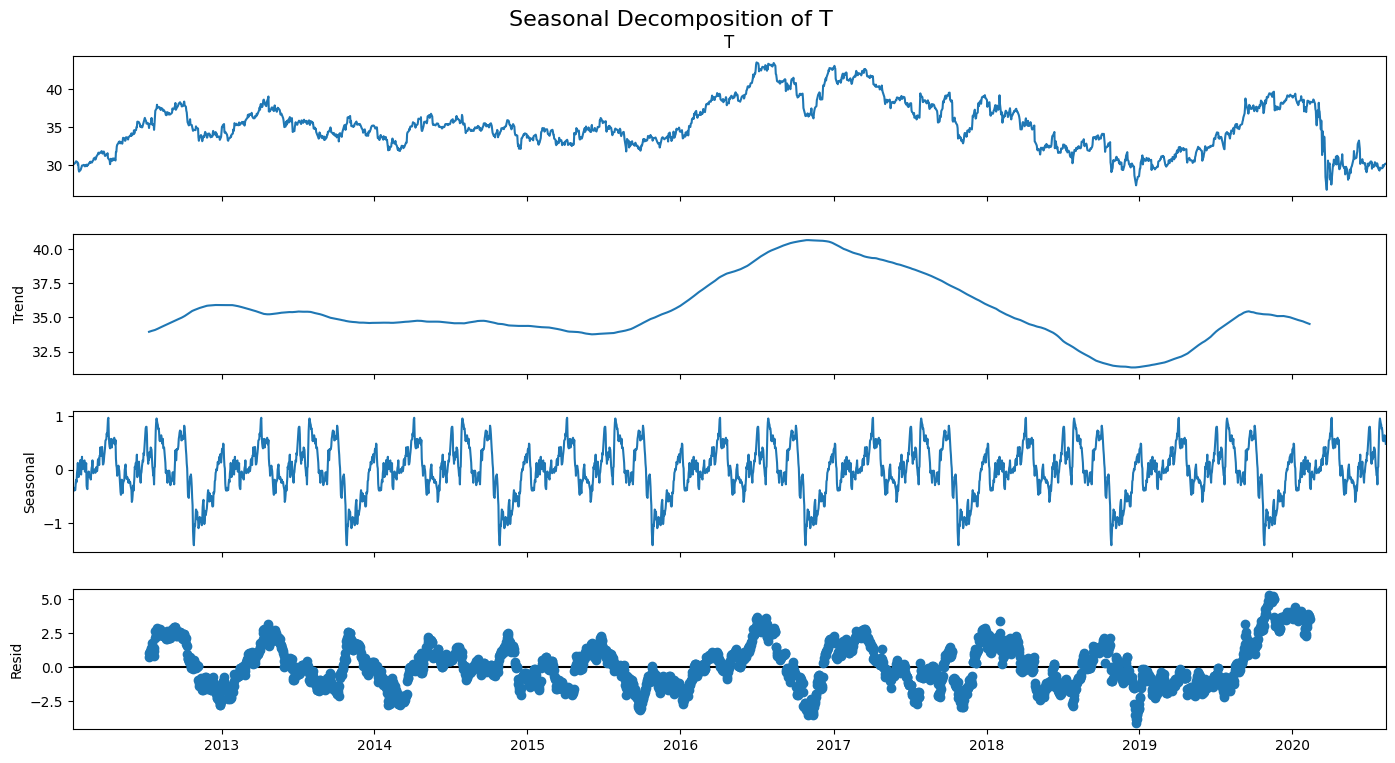

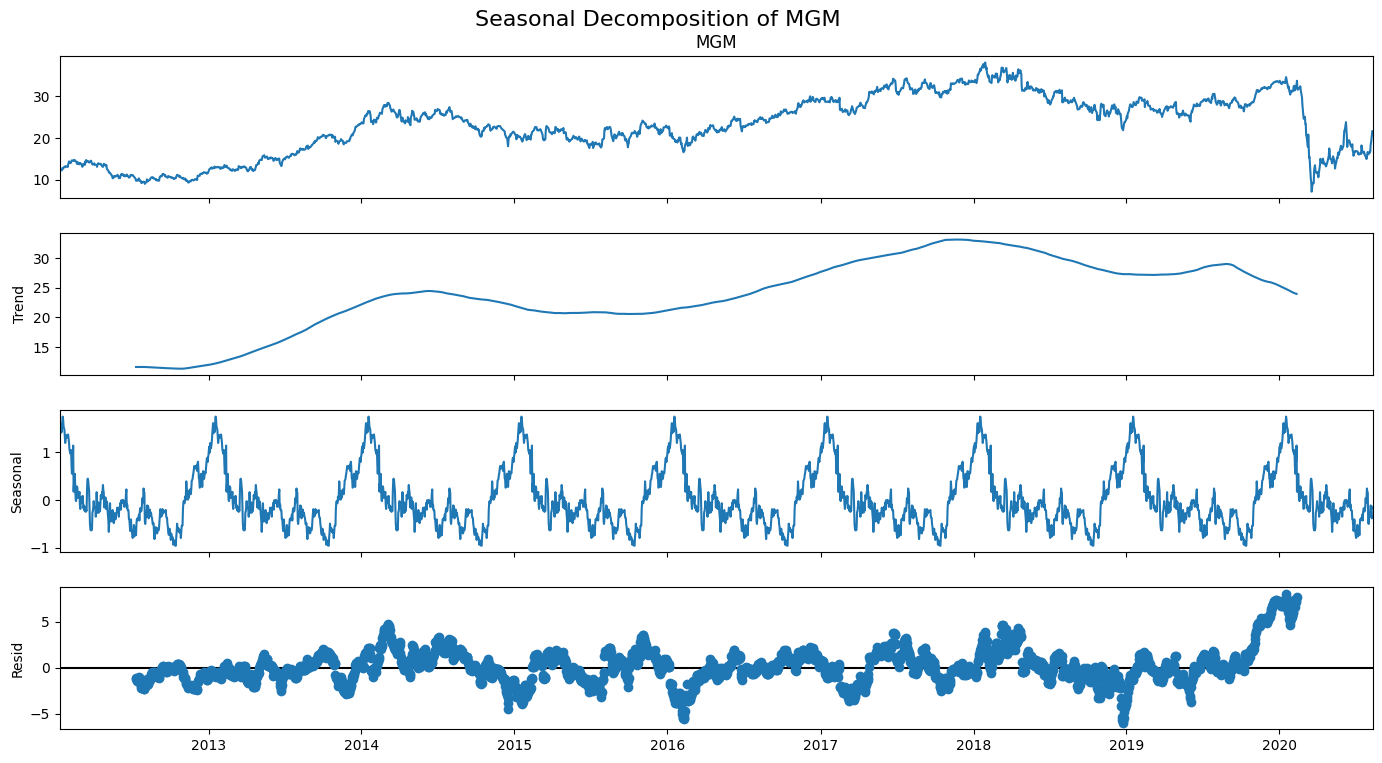

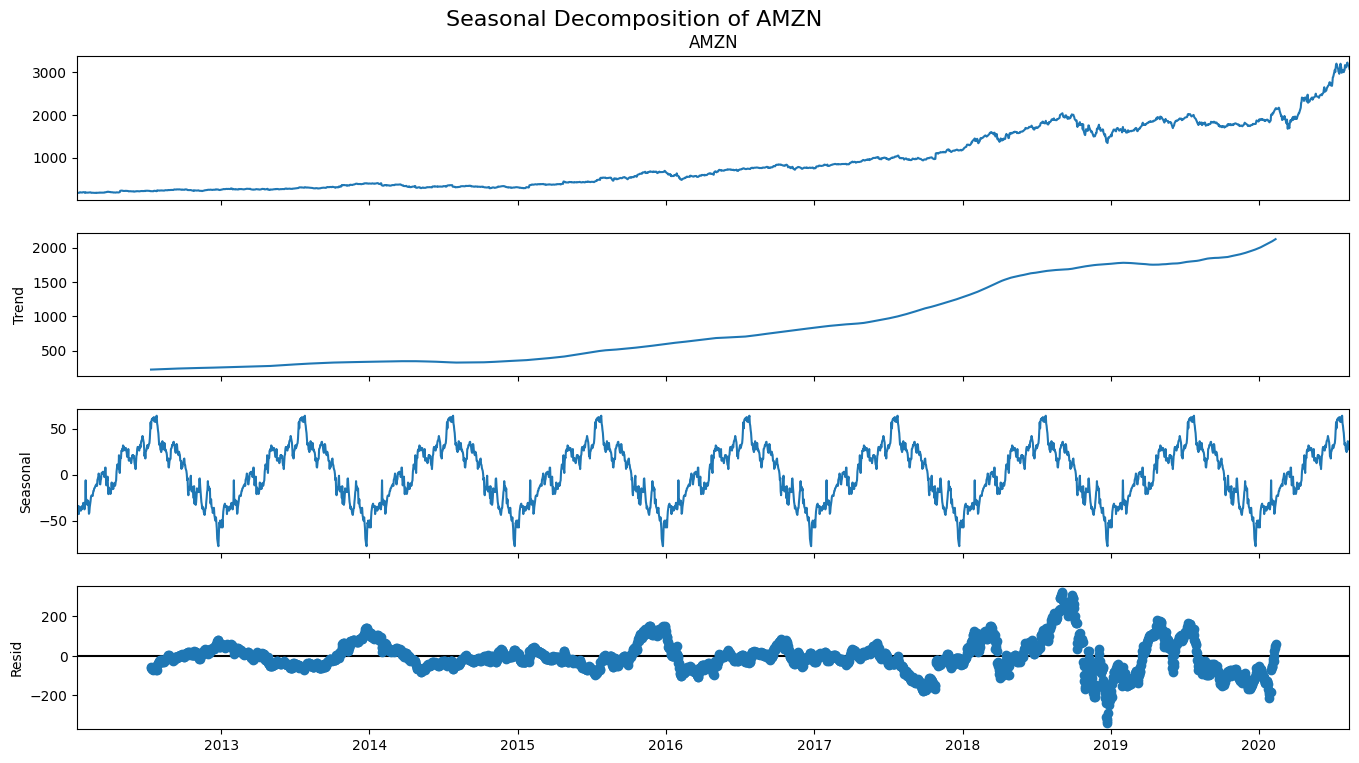

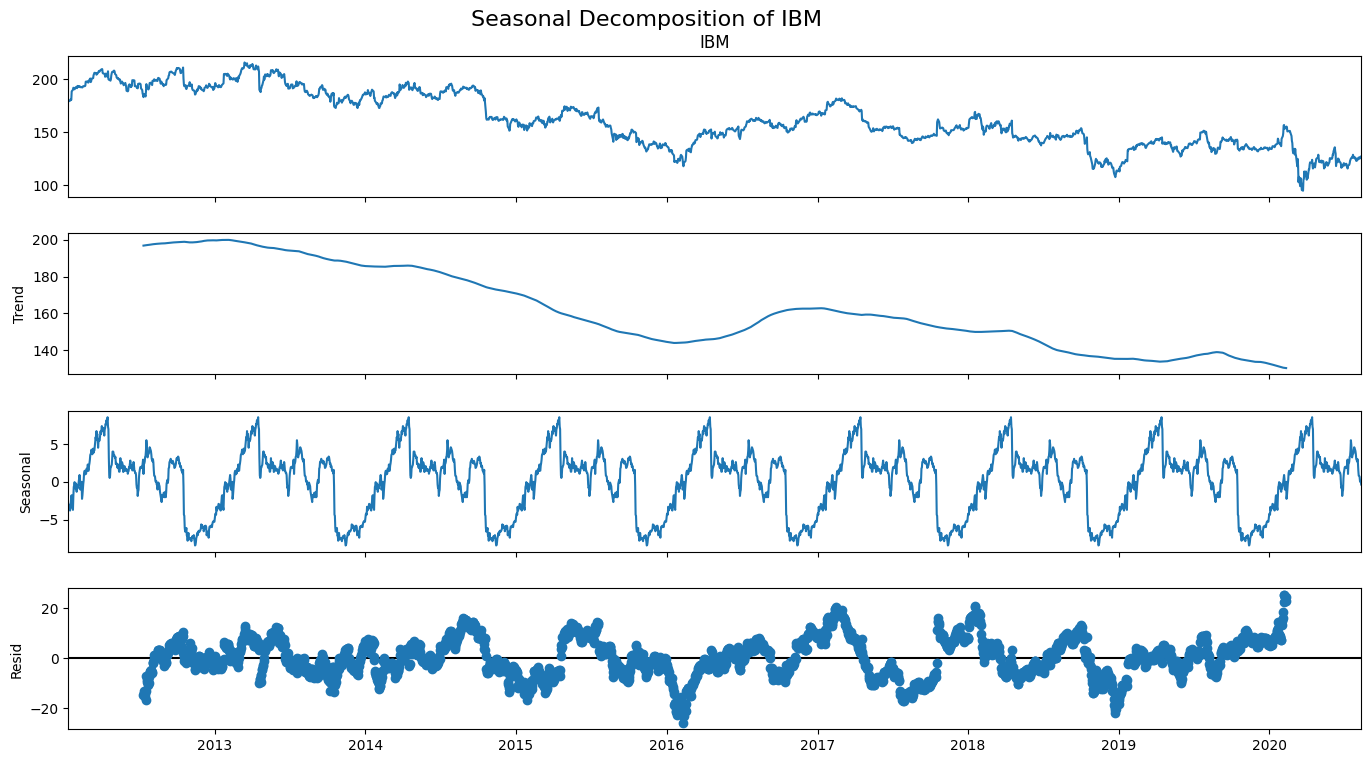

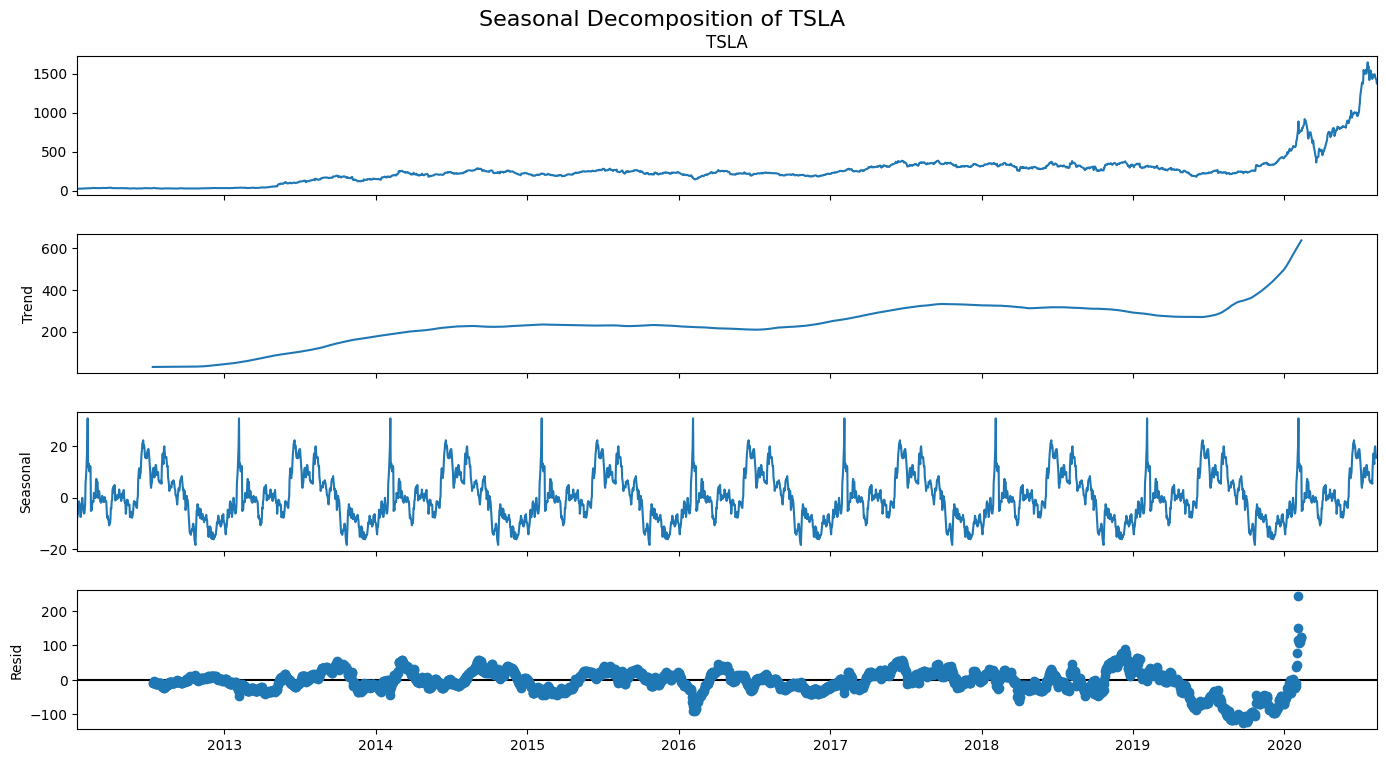

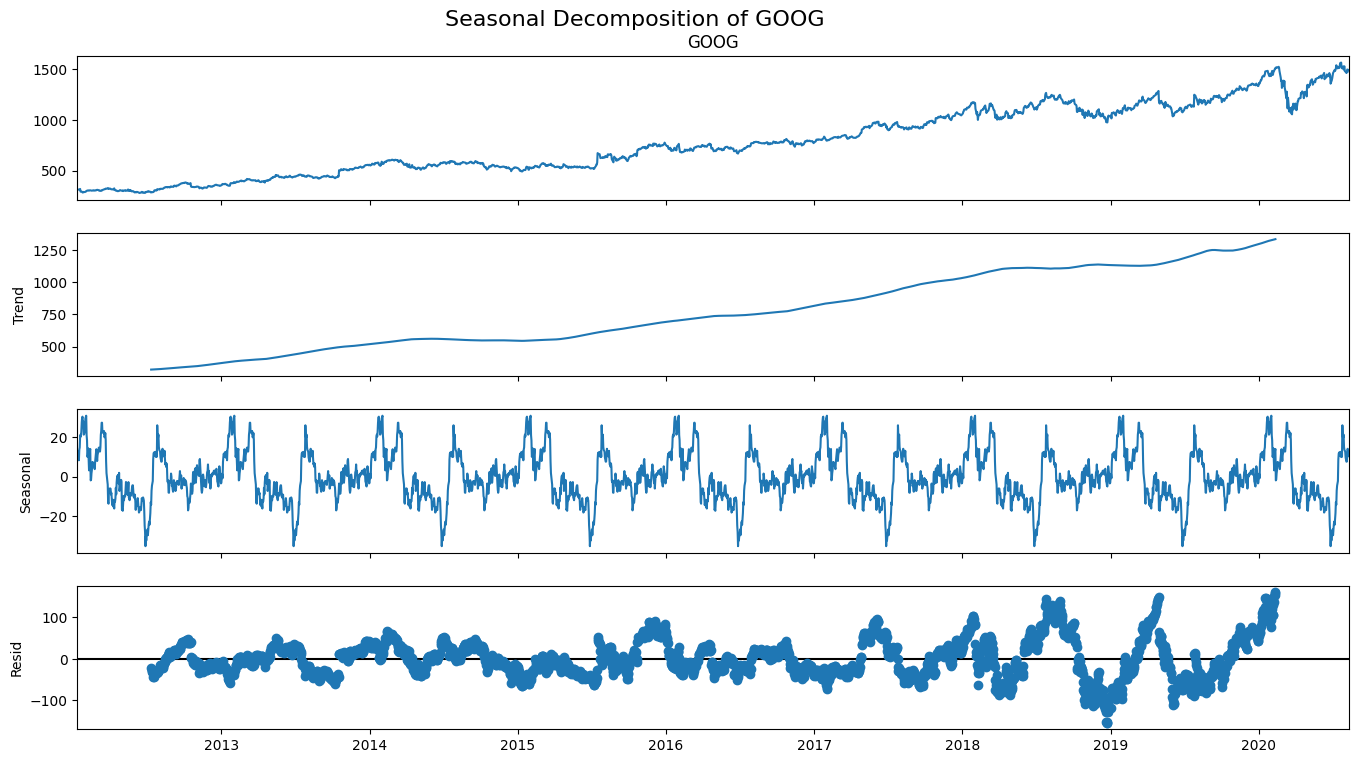

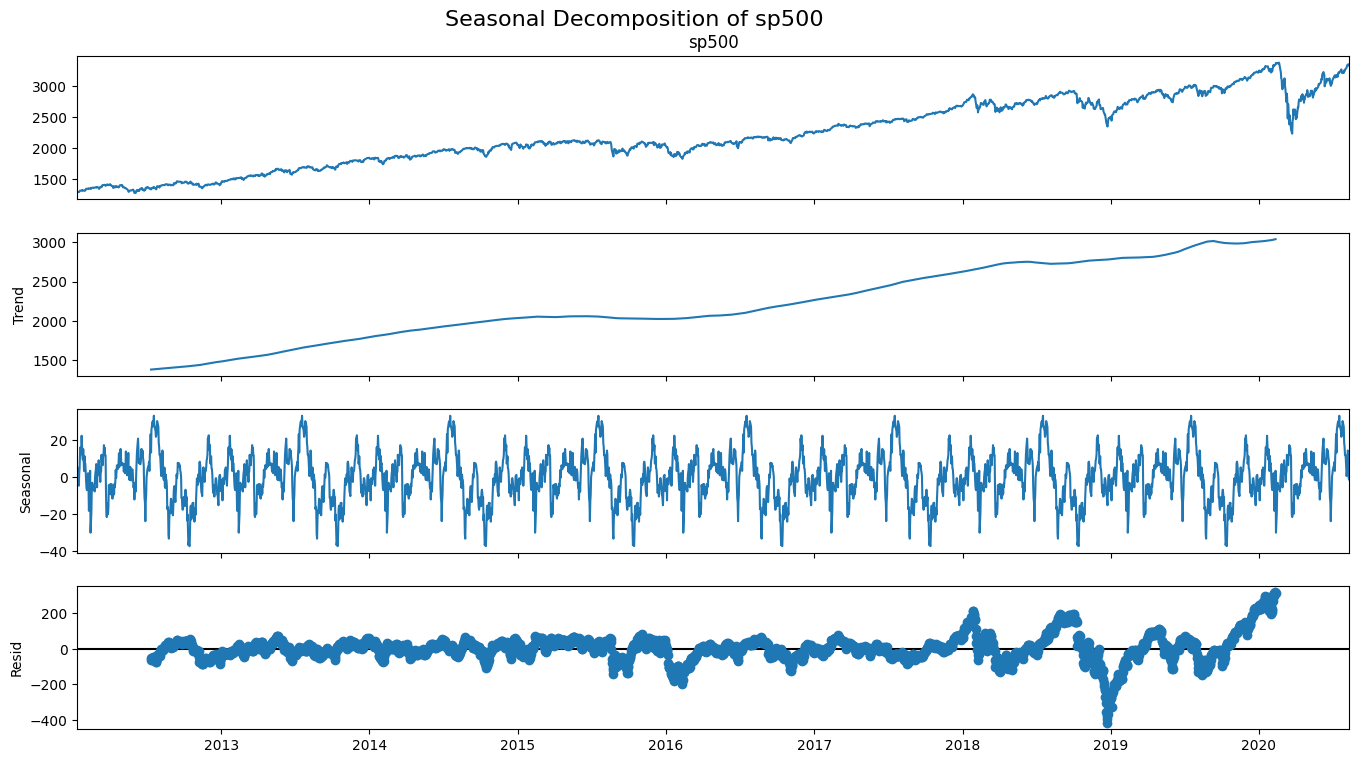

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose each company's time series
for column in data.columns:
    decomposition = seasonal_decompose(data[column], model='additive', period=365)  # Assuming yearly seasonality
    fig = decomposition.plot()
    fig.set_size_inches(15, 8)
    fig.suptitle(f'Seasonal Decomposition of {column}', fontsize=16)
    plt.show()

**3. Modelling the Time Series**

In [6]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARIMA model to each company's time series
model_fits = {}
for column in data.columns:
    model = ARIMA(data[column], order=(5, 1, 0))
    #p = number of past obesrvations to predict the current
    #d = difference between two observations (if it's 1 then we make differnce of yesterday and today)
    #q = incorporating past errors to correct current prediction
    model_fit = model.fit()
    model_fits[column] = model_fit
    print(f'ARIMA Model Summary for {column}')
    print(model_fit.summary())


ARIMA Model Summary for AAPL
                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                 3135
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -7236.713
Date:                Thu, 18 Jul 2024   AIC                          14485.426
Time:                        10:58:21   BIC                          14521.726
Sample:                    01-12-2012   HQIC                         14498.454
                         - 08-11-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0396      0.006     -6.275      0.000      -0.052      -0.027
ar.L2          0.0284      0.007      4.365      0.000       0.016       0.041
ar.L3          0.0072  

**4. Making Forecasts **

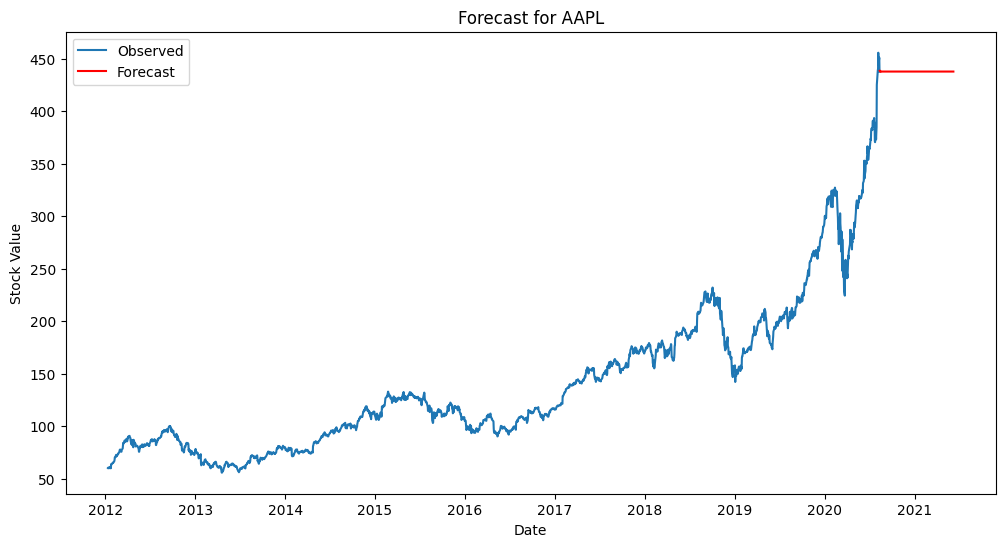

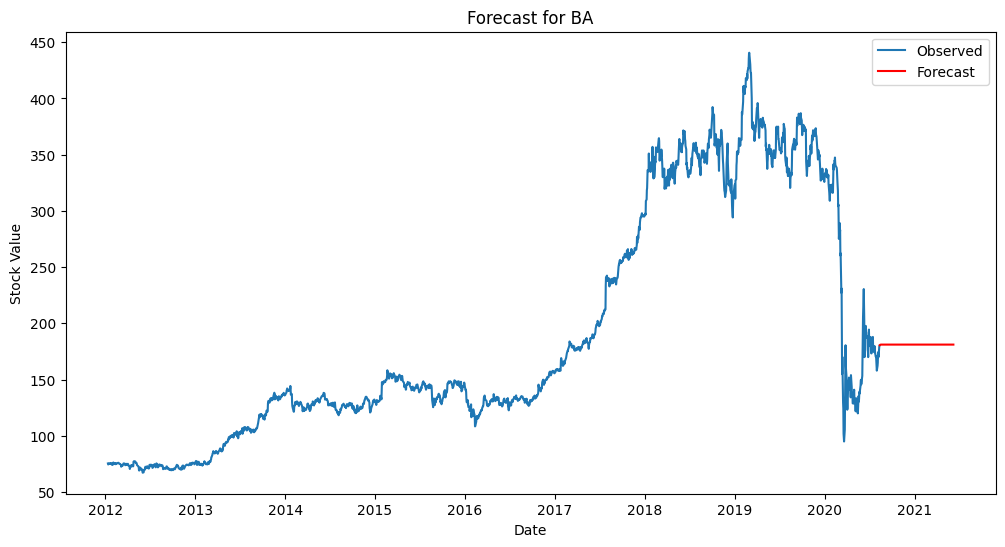

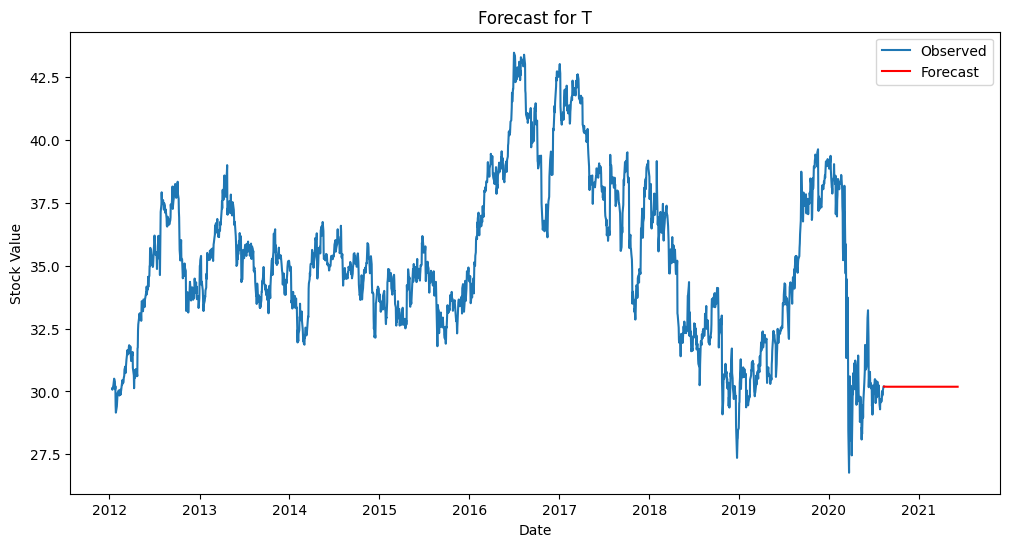

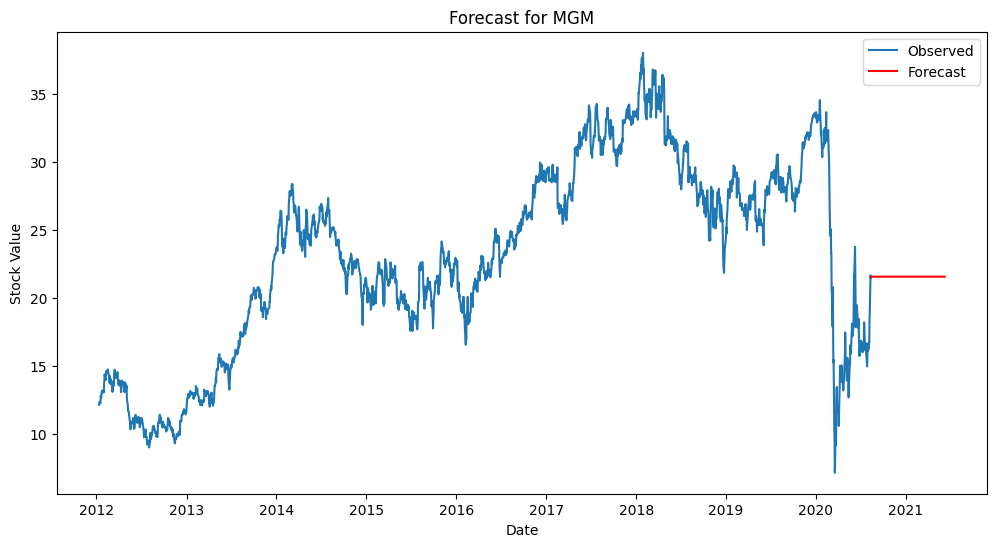

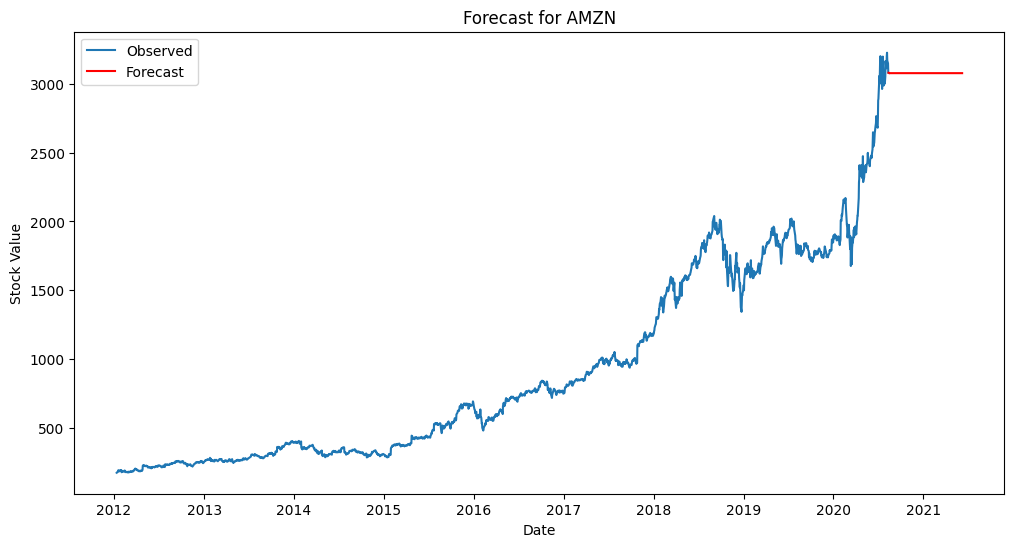

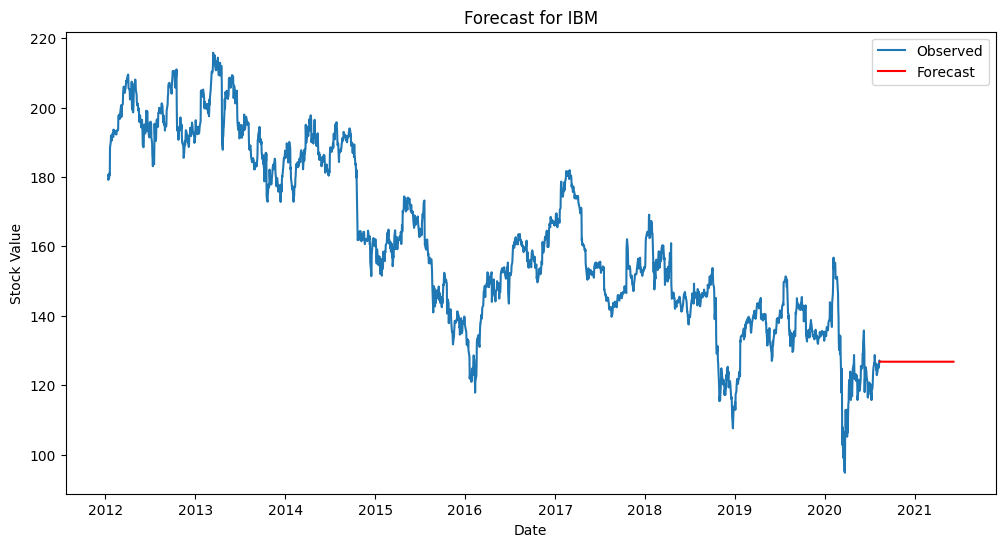

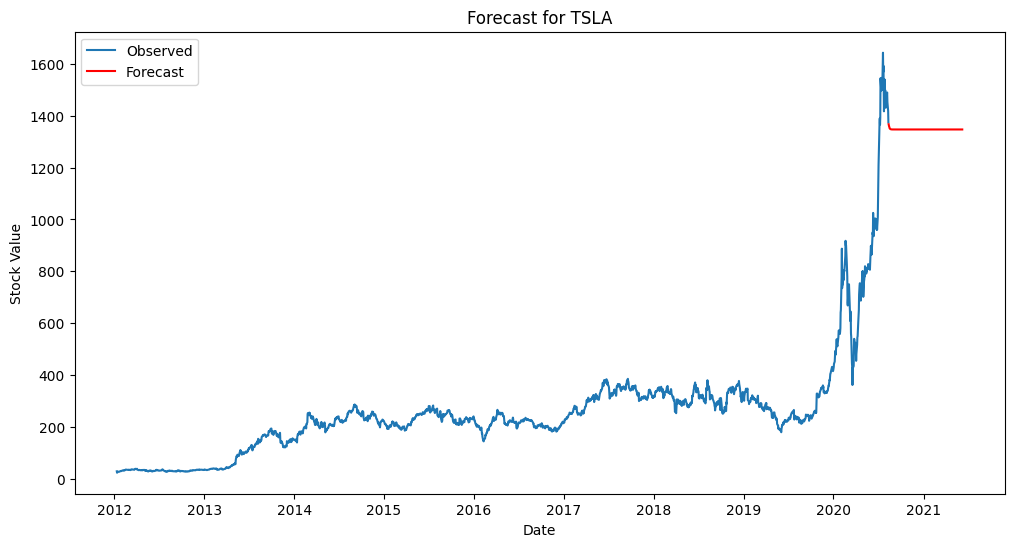

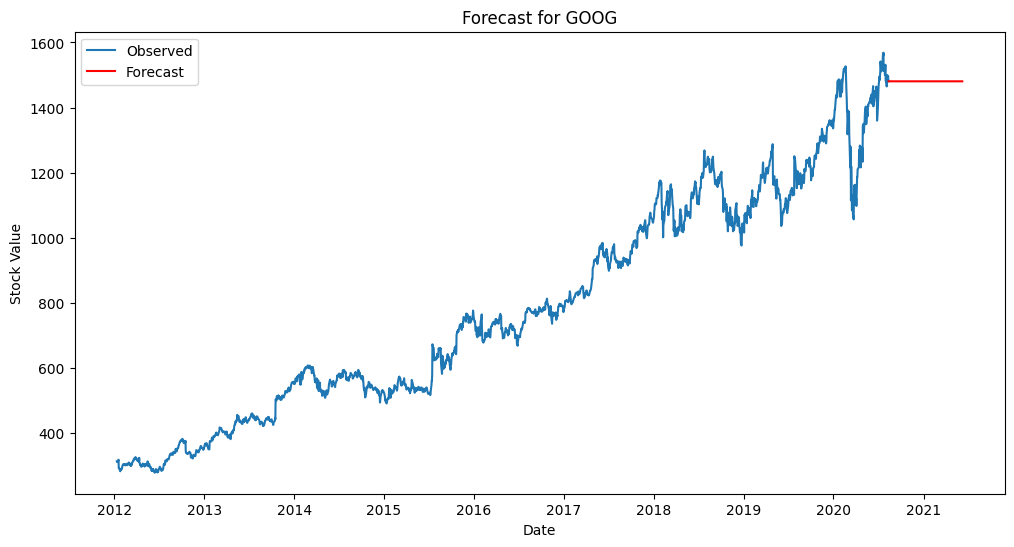

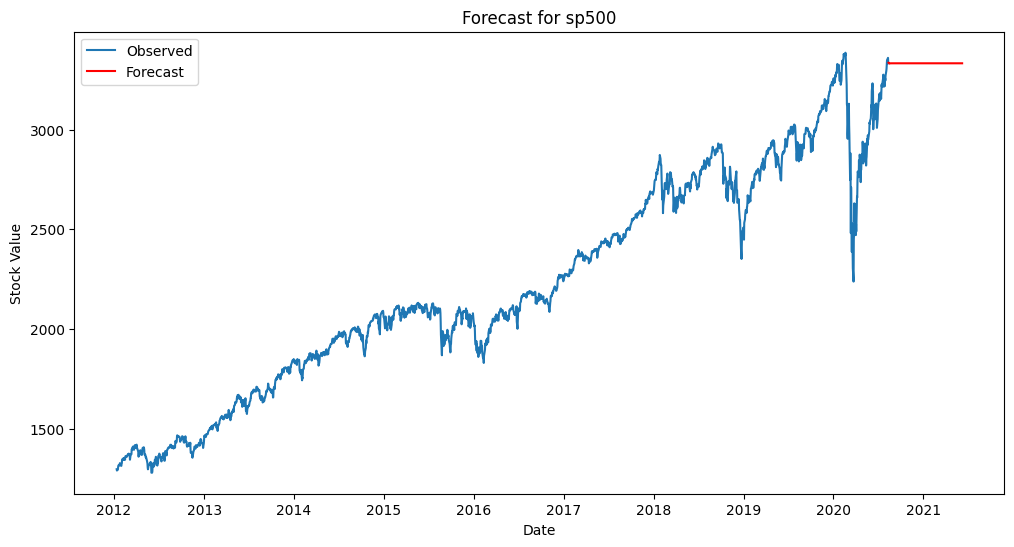

In [12]:
# Forecast for each company
forecasts = {} # create a new empty dictionary to store the forecaasted values
for column in data.columns: # start a loop for each column in the dataframe
    forecast = model_fits[column].forecast(steps=300)
    forecasts[column] = forecast

# Ensure the forecasts have the correct date index and plot the results
for column in data.columns:
    plt.figure(figsize=(12, 6))

    # Plot observed data
    plt.plot(data[column], label='Observed')

    # Generate a date range for the forecast
    last_date = data.index[-1]
    forecast_dates = pd.date_range(start=last_date, periods=301, inclusive='right')  # next 10 days

    # Plot the forecast data
    plt.plot(forecast_dates, forecasts[column], label='Forecast', color='red')

    # Add title and labels
    plt.title(f'Forecast for {column}')
    plt.xlabel('Date')
    plt.ylabel('Stock Value')
    plt.legend()
    plt.show()

**Model Evaluation - Analyzing how the model is working**

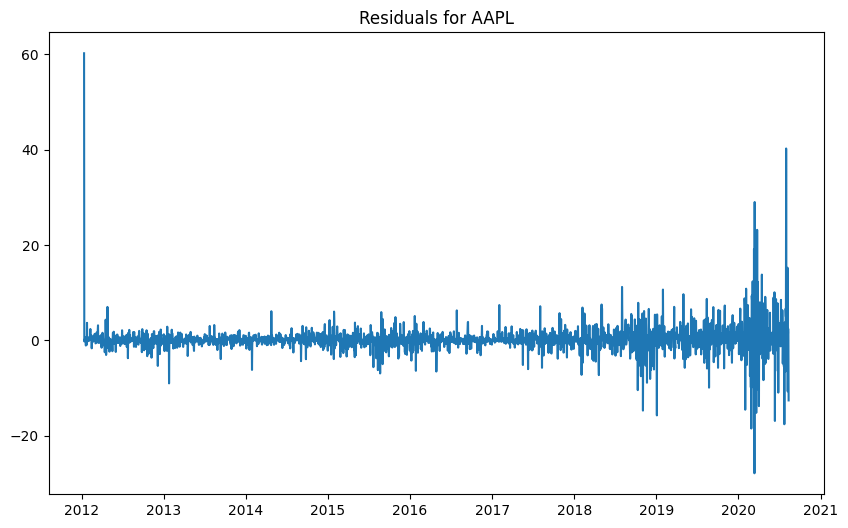

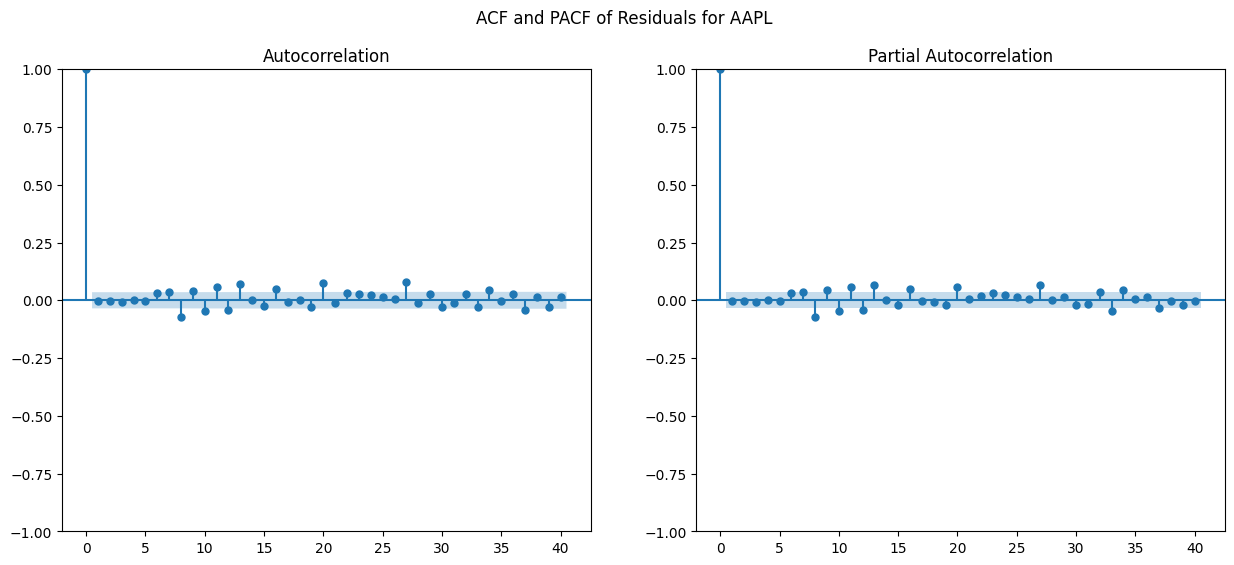

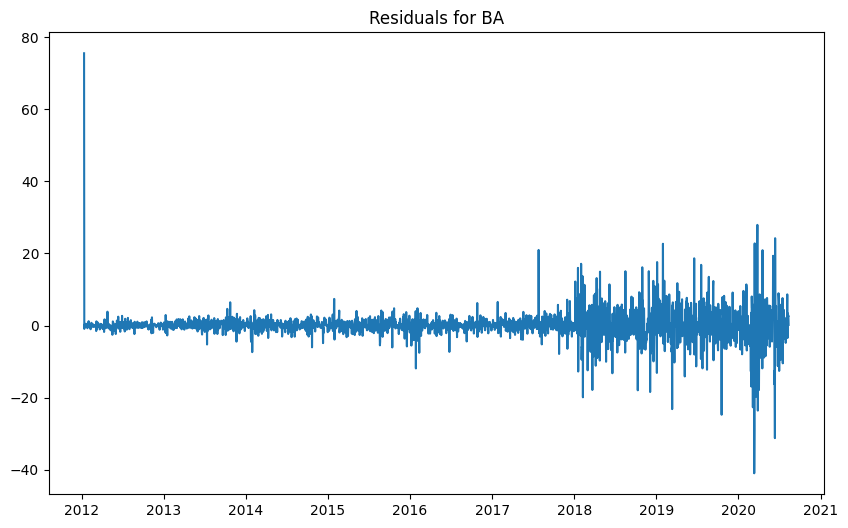

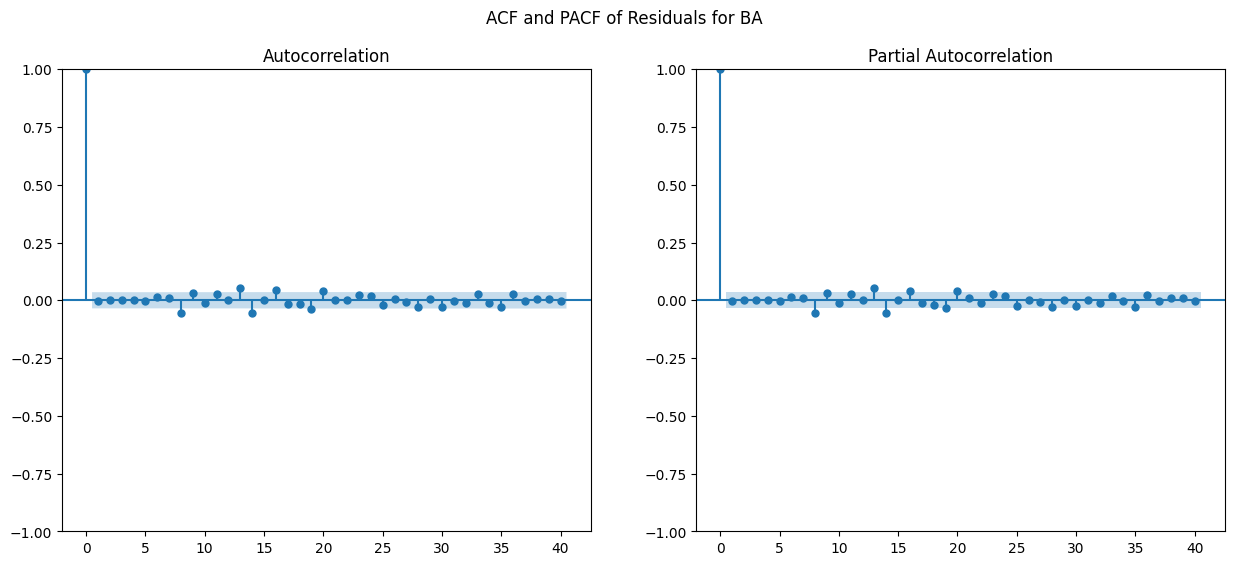

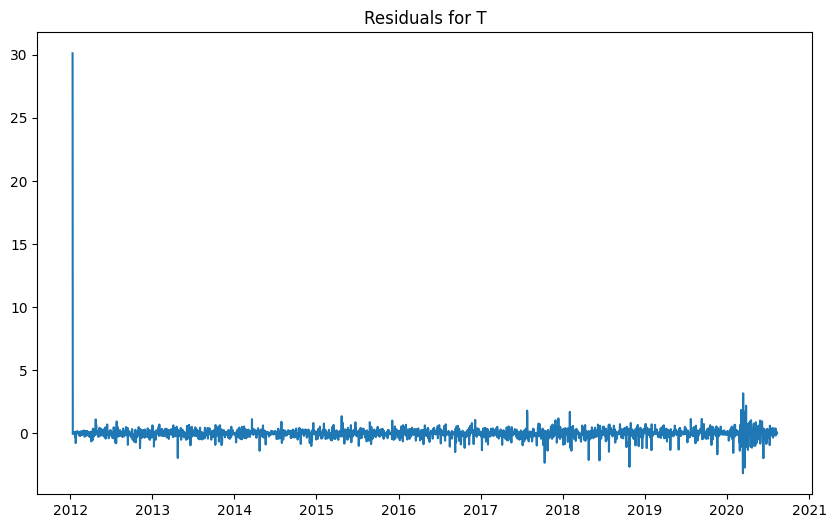

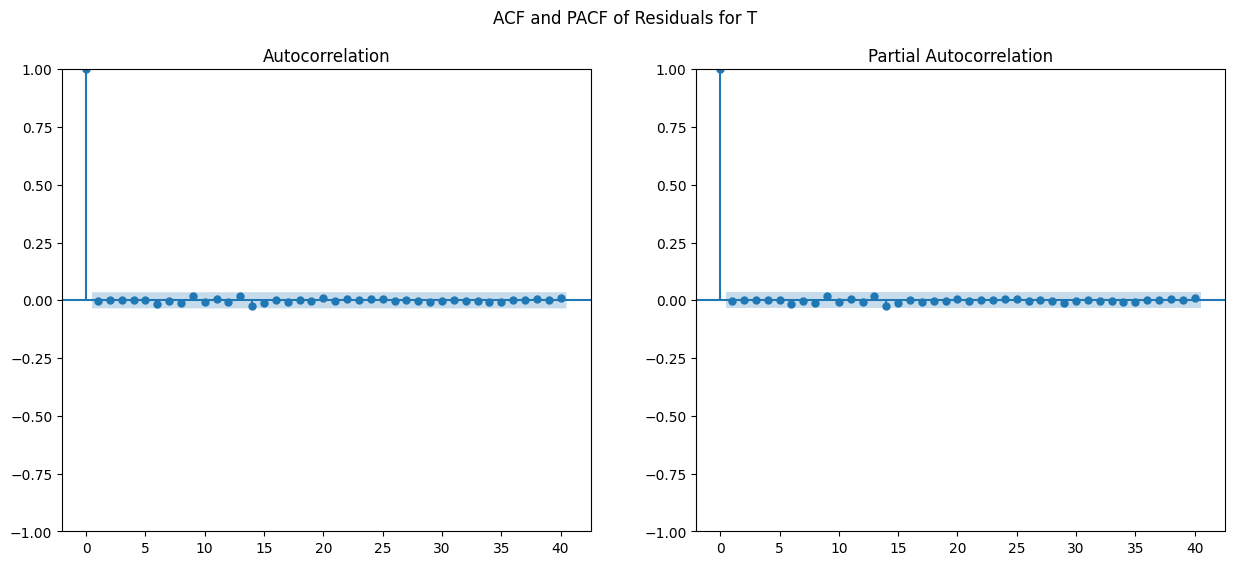

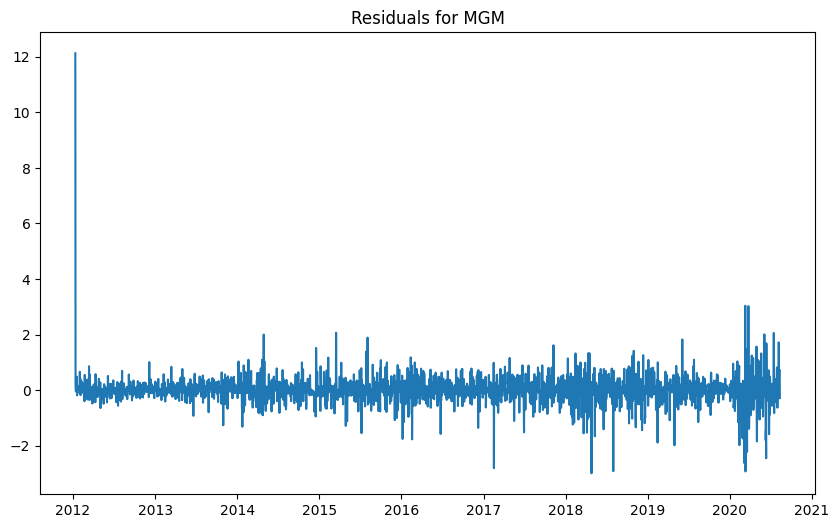

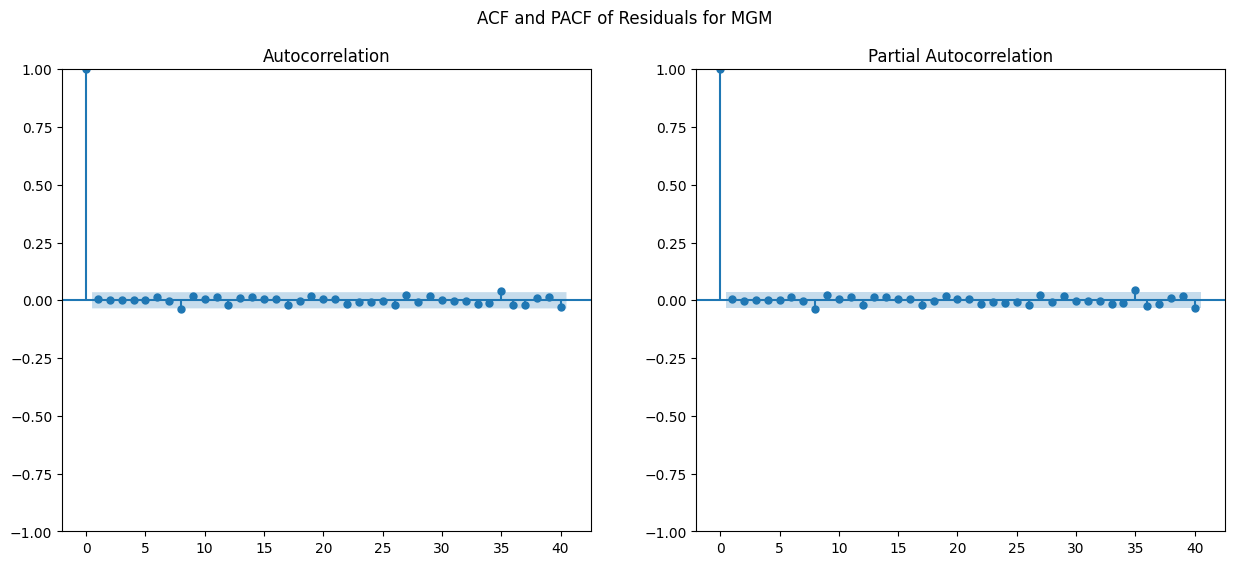

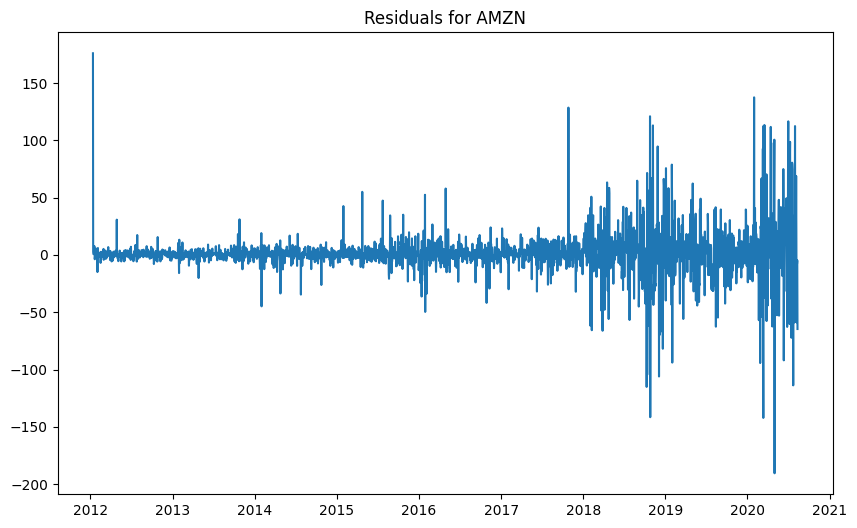

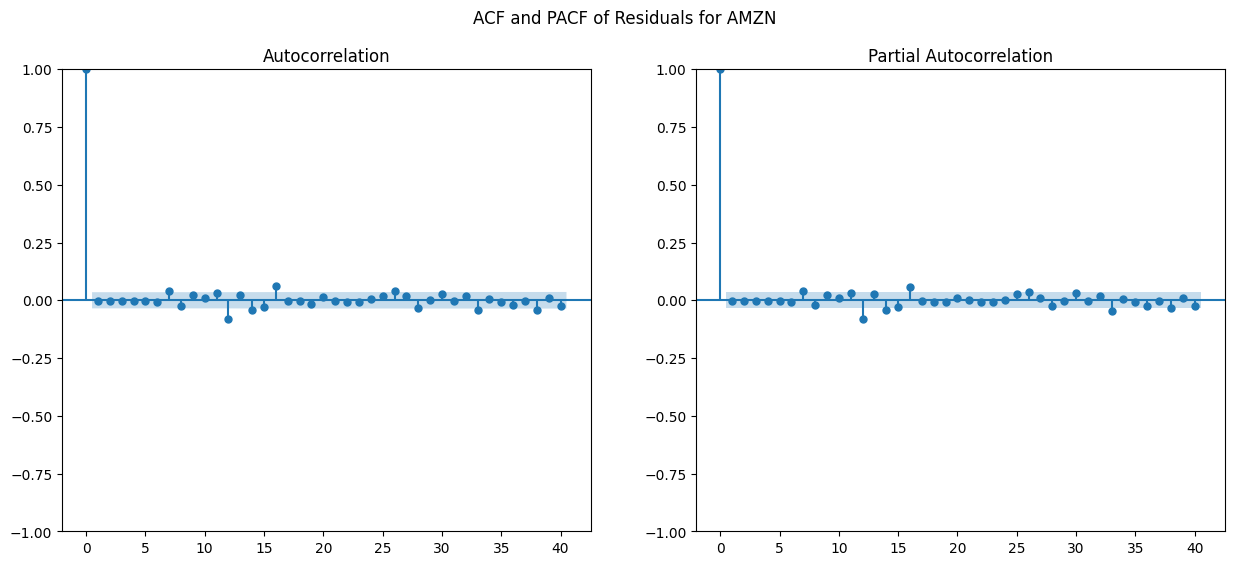

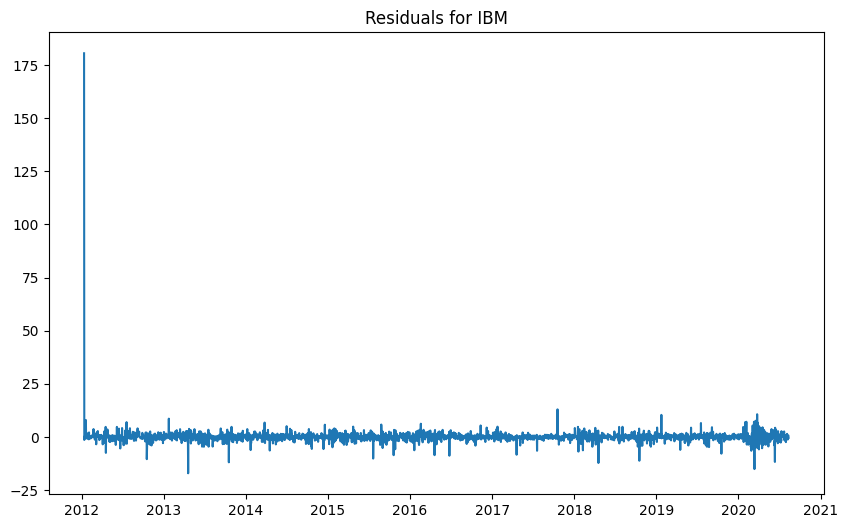

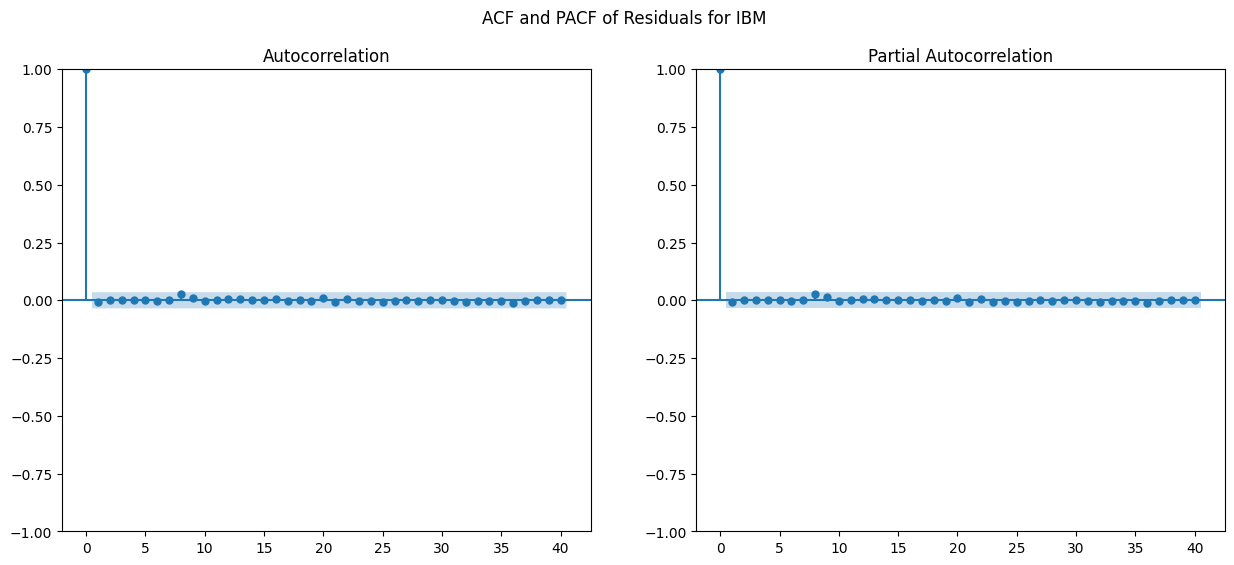

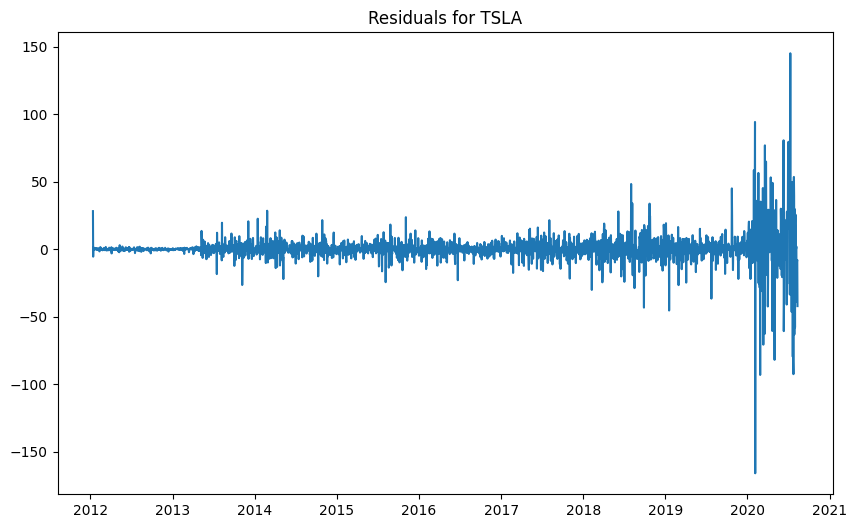

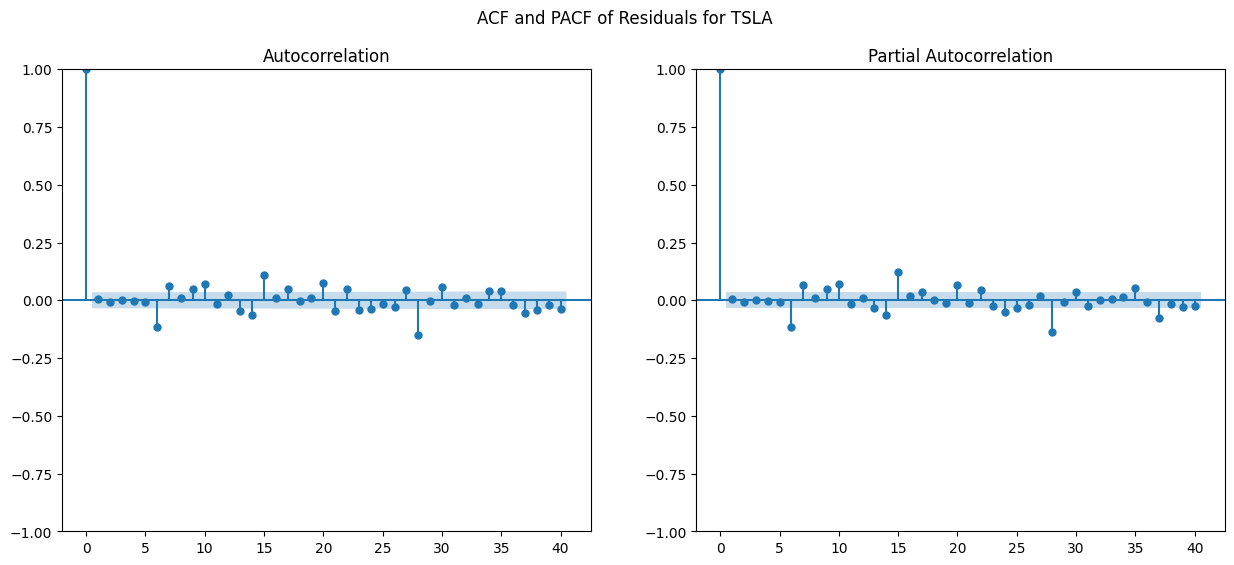

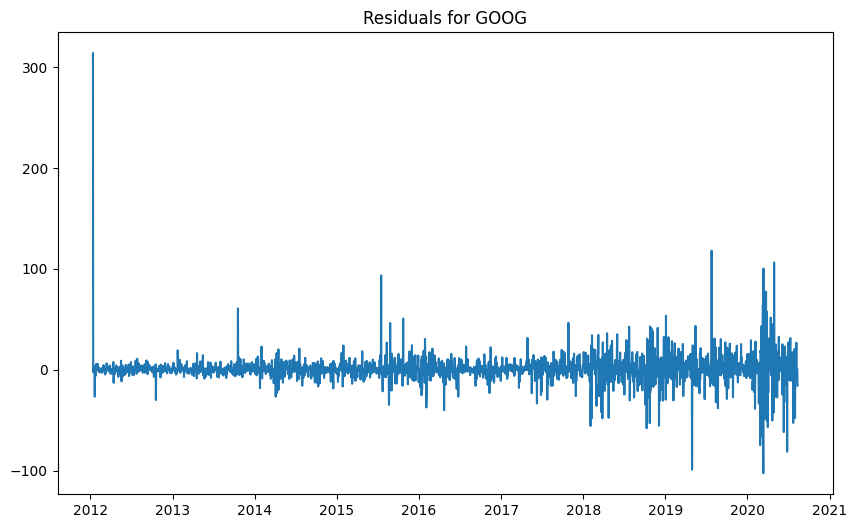

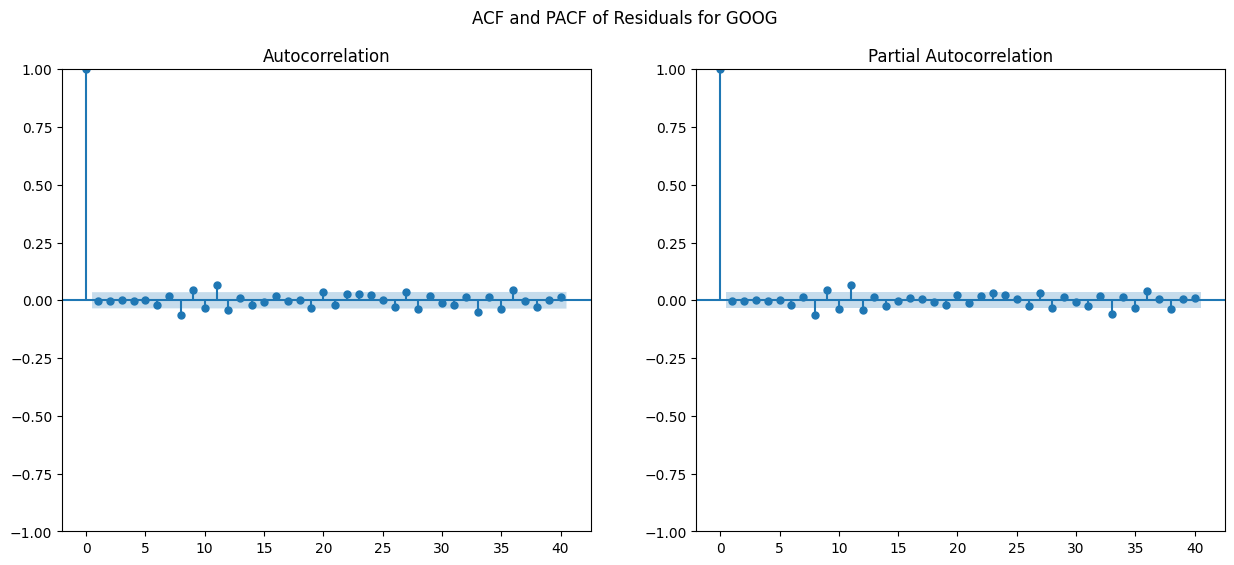

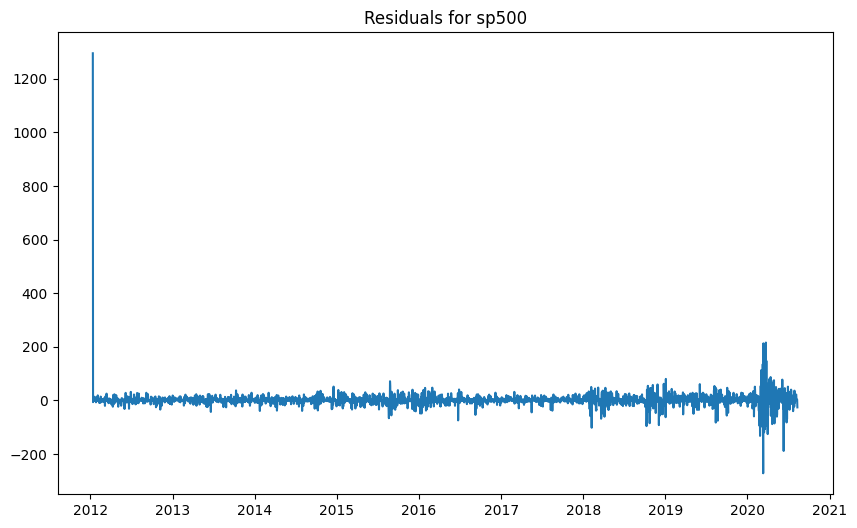

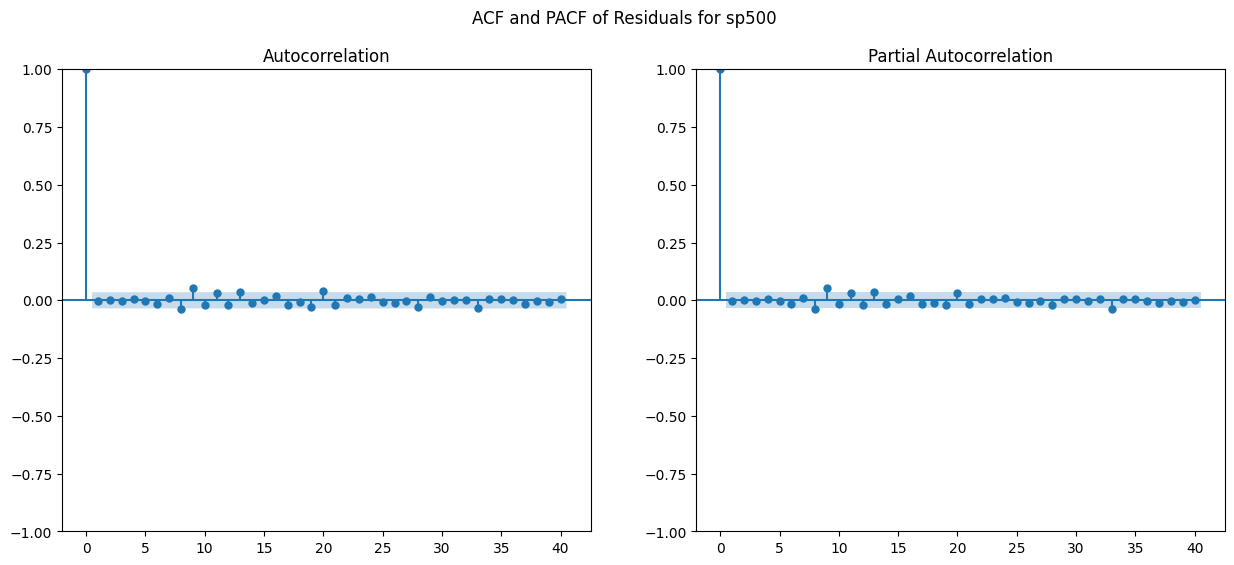

In [13]:
# Final part is make predictions and use ML methods to predict
import statsmodels.api as sm

# Perform diagnostics on the residuals
for column in data.columns:
    model_fit = model_fits[column]

    # Plot residuals
    residuals = model_fit.resid
    plt.figure(figsize=(10, 6))
    plt.plot(residuals)
    plt.title(f'Residuals for {column}')
    plt.show()

    # Plot ACF and PACF of residuals
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax[0])
    sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax[1])
    plt.suptitle(f'ACF and PACF of Residuals for {column}')
    plt.show()